<a href="https://colab.research.google.com/github/Yet-nde/CMM500-CODES/blob/main/Final_evaluation_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shap, time

#preprocessing & modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate,GroupShuffleSplit, GroupKFold, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_score,recall_score, f1_score, confusion_matrix, accuracy_score, precision_recall_curve,average_precision_score, roc_curve, make_scorer)
from sklearn.utils import resample
from imblearn.pipeline import Pipeline
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA

#visualisation
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = "/content/drive/MyDrive/2012dataset"

In [4]:
file_paths={
    'Sat':f'{folder_path}/TestbedSatJun12Flows.csv',
    'Sun':f'{folder_path}/TestbedSunJun13Flows.csv',
    'Mon':f'{folder_path}/TestbedMonJun14Flows.csv',
    'Tue':f'{folder_path}/TestbedTueJun15Flows.csv',
    'Wed':f'{folder_path}/TestbedWedJun16Flows.csv',
    'Thu':f'{folder_path}/TestbedThuJun17Flows.csv'
} #dictionary
frames=[]
for day,path in file_paths.items():
    df_2012=pd.read_csv(path)
    df_2012['day']=day
    frames.append(df_2012)

df=pd.concat(frames,ignore_index=True)
pd.set_option('display.max_columns',None)

In [5]:
df['session_id'] = (
    df['source'].astype(str) + '_' +
    df['destination'].astype(str) + '_' +
    df['sourcePort'].astype(str) + '_' +
    df['destinationPort'].astype(str) + '_' +
    df['protocolName'].astype(str) + '_' +
    df['direction'].astype(str)
)
df.head()


,generated,appName,totalSourceBytes,totalDestinationBytes,totalDestinationPackets,totalSourcePackets,sourcePayloadAsBase64,sourcePayloadAsUTF,destinationPayloadAsBase64,destinationPayloadAsUTF,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,source,protocolName,sourcePort,destination,destinationPort,startDateTime,stopDateTime,Label,day,session_id
0,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22441,216.246.64.49,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.1.104_216.246.64.49_22441_80_tcp_ip_L2R
1,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22445,216.246.64.66,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.1.104_216.246.64.66_22445_80_tcp_ip_L2R
2,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22444,216.246.64.66,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.1.104_216.246.64.66_22444_80_tcp_ip_L2R
3,3/11/2014 17:23,SSH,2938,49570,76,27,NaN,NaN,NaN,NaN,L2L,"S,R,P,A","S,P,A",192.168.3.115,tcp_ip,3248,192.168.5.122,22,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.3.115_192.168.5.122_3248_22_tcp_ip_L2L
4,3/11/2014 17:23,HTTPImageTransfer,644,2315,5,7,NaN,NaN,NaN,NaN,L2R,"S,P,A","S,P,A",192.168.2.110,tcp_ip,1867,142.166.14.77,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.2.110_142.166.14.77_1867_80_tcp_ip_L2R


In [6]:
session_cols=['totalSourceBytes','totalDestinationBytes','totalSourcePackets','totalDestinationPackets','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription'] #drop time because it does not help the model according to SHAP
                                                                                    #analysis performed and over 83% are zero duration sessions
df=df[session_cols+['Label','session_id']]
df=df.copy()

In [7]:
#packet ratio
df['packet_ratio']=df['totalSourcePackets']/df['totalDestinationPackets'].replace(0,np.nan)
df['packet_ratio']=df['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
df['byte_ratio']=df['totalSourceBytes']/df['totalDestinationBytes'].replace(0,np.nan)
df['byte_ratio']=df['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
df['avg_packet_size_src']=df['totalSourceBytes']/df['totalSourcePackets'].replace(0,np.nan)
df['avg_packet_size_src']=df['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
df['avg_packet_size_dst']=df['totalDestinationBytes']/df['totalDestinationPackets'].replace(0,np.nan)
df['avg_packet_size_dst']=df['avg_packet_size_dst'].fillna(0).clip(upper=1500)

In [8]:
cat_cols=['sourceTCPFlagsDescription','destinationTCPFlagsDescription']
label_encoders = {}
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")
    le = LabelEncoder()
    df[ col] = le.fit_transform(df[col])
    label_encoders[col] = le


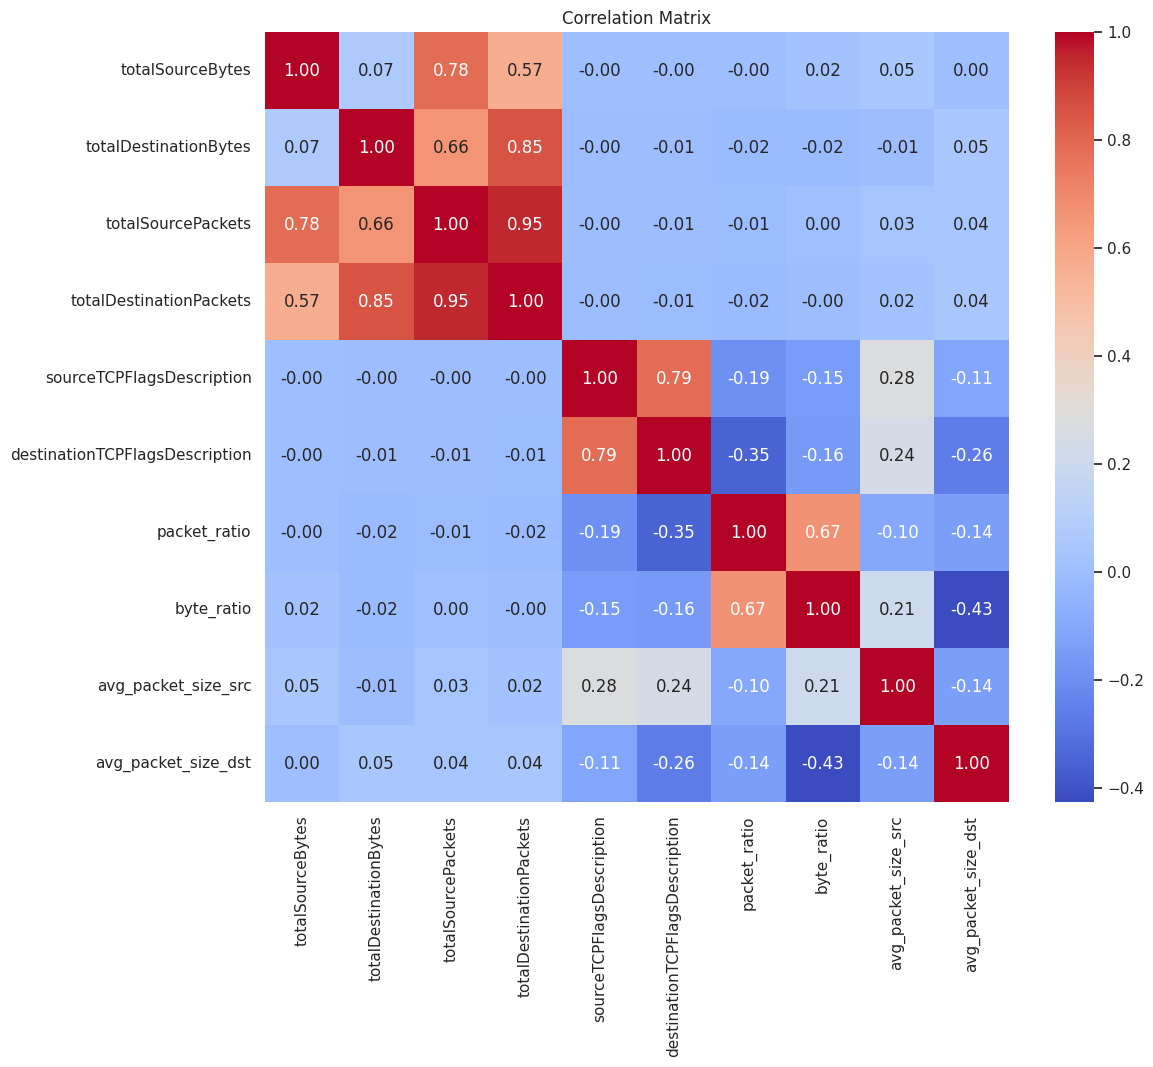

In [9]:
# Correlation matrix
numeric_cols = df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [10]:
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation above threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
    return df_reduced

In [11]:
df_numeric = df.select_dtypes(include=np.number)
df_reduced = drop_highly_correlated(df_numeric)
df_model = pd.concat([df_reduced, df[["Label",'session_id']]], axis=1)

Dropped 1 columns due to high correlation: ['totalDestinationPackets']


In [12]:
df.head()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,sourceTCPFlagsDescription,destinationTCPFlagsDescription,Label,session_id,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst
0,128,64,2,1,1,1,Normal,192.168.1.104_216.246.64.49_22441_80_tcp_ip_L2R,2.000000,2.000000,64.000000,64.000000
1,128,64,2,1,1,1,Normal,192.168.1.104_216.246.64.66_22445_80_tcp_ip_L2R,2.000000,2.000000,64.000000,64.000000
2,128,64,2,1,1,1,Normal,192.168.1.104_216.246.64.66_22444_80_tcp_ip_L2R,2.000000,2.000000,64.000000,64.000000
3,2938,49570,27,76,22,22,Normal,192.168.3.115_192.168.5.122_3248_22_tcp_ip_L2L,0.355263,0.059270,108.814815,652.236842
4,644,2315,7,5,18,22,Normal,192.168.2.110_142.166.14.77_1867_80_tcp_ip_L2R,1.400000,0.278186,92.000000,463.000000


In [13]:
# Prepare features and labels
X = df_model.drop(["Label",'session_id'], axis=1)
y = df_model["Label"].map({"Normal": 0, "Attack": 1})
groups=df_model['session_id']

# Hold out 20% for evaluation
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, final_eval_idx = next(gss.split(X, y, groups=groups))
X_train_cv, X_final = X.iloc[train_idx], X.iloc[final_eval_idx]
y_train_cv, y_final = y.iloc[train_idx], y.iloc[final_eval_idx]
groups_train_cv = groups.iloc[train_idx]

print(f"Training samples for CV: {X_train_cv.shape[0]}")
print(f"Final evaluation samples: {X_final.shape[0]}")
print(f"Unique sessions in CV train: {len(set(groups_train_cv))}")
print(f"Unique sessions in Final Evaluation: {len(set(groups.iloc[final_eval_idx]))}")


Training samples for CV: 1659490
Final evaluation samples: 412167
Unique sessions in CV train: 881629
Unique sessions in Final Evaluation: 220408


In [14]:
# Define models and hyperparameter grids
models = {
    "RF": {
        "estimator": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_distributions": {
            "n_estimators": [100, 200,300],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5,10]
        },
        "n_iter": 10
    },

   "XGBoost": {
        "estimator": XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=1),
        "param_distributions": {
            "n_estimators": [100, 200,300],
            "max_depth": [3, 6, 10],
            "learning_rate": [0.01, 0.5,0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        },
        "n_iter": 15
        }
    }


In [15]:
# Cross-Validation with RandomizedSearchCV
best_models = {}
gkf = GroupKFold(n_splits=3)
roc_auc_scorer = make_scorer(roc_auc_score, response_method="predict_proba")

for name, m in models.items():
    print(f"\nTuning {name}...")
    search = RandomizedSearchCV(
        estimator=m["estimator"],
        param_distributions=m["param_distributions"],
        n_iter=m["n_iter"],
        scoring=roc_auc_scorer,
        cv=gkf.split(X_train_cv, y_train_cv, groups=groups_train_cv),
        n_jobs=-4,
        random_state=42,
        verbose=1
    )
    start = time.time()
    search.fit(X_train_cv, y_train_cv)
    end = time.time()
    print(f"{name} best params: {search.best_params_}")
    print(f"CV ROC AUC: {search.best_score_:.4f}")
    print(f"Tuning time: {end - start:.2f} sec")
    best_models[name] = search.best_estimator_


Tuning RF...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RF best params: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 20}
CV ROC AUC: 0.9987
Tuning time: 13731.02 sec

Tuning XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
XGBoost best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV ROC AUC: 0.9988
Tuning time: 695.98 sec



RF Evaluation on Held-out 20%:
Training time: 1280.27 sec
Prediction time: 9.18 sec
              precision    recall  f1-score   support

           0     0.9986    0.9991    0.9989    398318
           1     0.9751    0.9594    0.9672     13849

    accuracy                         0.9978    412167
   macro avg     0.9869    0.9793    0.9830    412167
weighted avg     0.9978    0.9978    0.9978    412167

ROC AUC: 0.9990
Average Precision: 0.9924
Confusion Matrix:
[[397979    339]
 [   562  13287]]

XGBoost Evaluation on Held-out 20%:
Training time: 19.02 sec
Prediction time: 3.01 sec
              precision    recall  f1-score   support

           0     0.9986    0.9991    0.9989    398318
           1     0.9742    0.9600    0.9670     13849

    accuracy                         0.9978    412167
   macro avg     0.9864    0.9796    0.9830    412167
weighted avg     0.9978    0.9978    0.9978    412167

ROC AUC: 0.9987
Average Precision: 0.9913
Confusion Matrix:
[[397966    352]
 

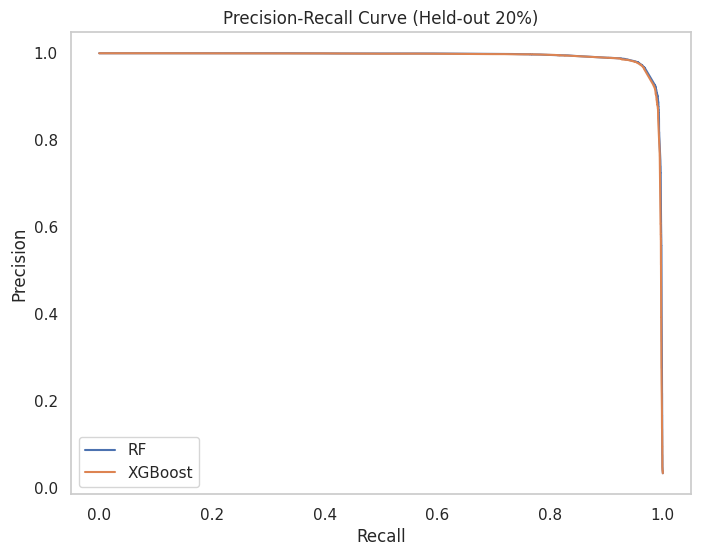


Timing summary:
         train_time  pred_time
RF          1280.27       9.18
XGBoost       19.02       3.01


In [16]:
# Evaluate best models on held out 20%
plt.figure(figsize=(8, 6))
timings = {}

for name, model in best_models.items():
    start_train = time.time()
    model.fit(X_train_cv, y_train_cv)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred_final = model.predict(X_final)
    y_proba_final = model.predict_proba(X_final)[:, 1]
    pred_time = time.time() - start_pred

    print(f"\n{name} Evaluation on Held-out 20%:")
    print(f"Training time: {train_time:.2f} sec")
    print(f"Prediction time: {pred_time:.2f} sec")
    print(classification_report(y_final, y_pred_final, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_final, y_proba_final):.4f}")
    print(f"Average Precision: {average_precision_score(y_final, y_proba_final):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_final, y_pred_final))

    precision, recall, _ = precision_recall_curve(y_final, y_proba_final)
    plt.plot(recall, precision, label=name)
    timings[name] = {"train_time": round(train_time, 2), "pred_time": round(pred_time, 2)}

plt.title("Precision-Recall Curve (Held-out 20%)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

print("\nTiming summary:")
print(pd.DataFrame(timings).T)

In [22]:
# Sample for held test set
shap_sample_size=5000
top_n_features=5
X_sample = X_final.sample(n=min(shap_sample_size, len(X_final)), random_state=42)

# XGBoost SHAP
xgb_model_fitted = best_models["XGBoost"]
explainer = shap.TreeExplainer(xgb_model_fitted)
xgb_output = explainer(X_sample)

# Handle binary vs multiclass
if xgb_output.values.ndim == 3:
    xgb_shap_values = xgb_output.values[:, :, 1] #attack
else:
    xgb_shap_values = xgb_output.values

# Wrap SHAP values into DataFrame for easy handling
shap_df = pd.DataFrame(xgb_shap_values, columns=X_sample.columns)

# Inspect
print("XGB SHAP shape:", xgb_shap_values.shape)
print("X_sample shape:", X_sample.shape)

XGB SHAP shape: (5000, 9)
X_sample shape: (5000, 9)


In [23]:
# Global feature importance
mean_abs_shap = np.abs(shap_df).mean(axis=0)
top_feats = mean_abs_shap.sort_values(ascending=False).head(top_n_features)
print("\nTop features by mean |SHAP|:")
print(top_feats)


Top features by mean |SHAP|:
totalSourceBytes             1.170821
avg_packet_size_src          1.092174
sourceTCPFlagsDescription    0.848862
avg_packet_size_dst          0.768267
packet_ratio                 0.750824
dtype: float32


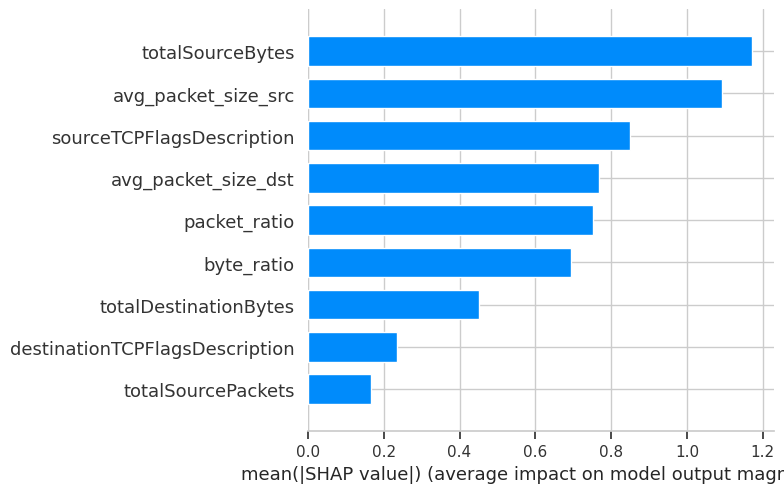

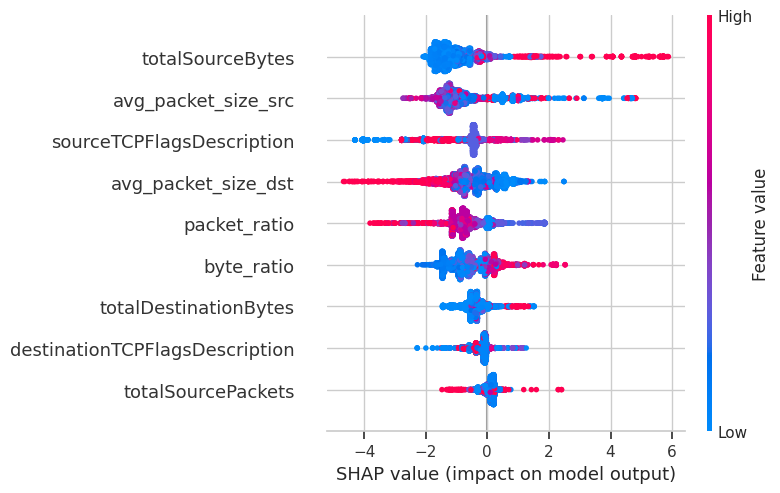

In [24]:
# Summary plots
plt.figure()
shap.summary_plot(xgb_shap_values, X_sample, plot_type="bar", show=True)
plt.figure()
shap.summary_plot(xgb_shap_values, X_sample, plot_type="dot", show=True)


 Dependence plot for: totalSourceBytes


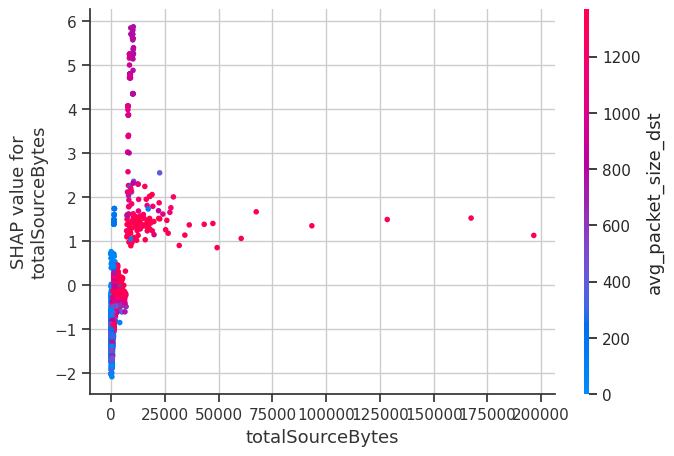


 Dependence plot for: avg_packet_size_src


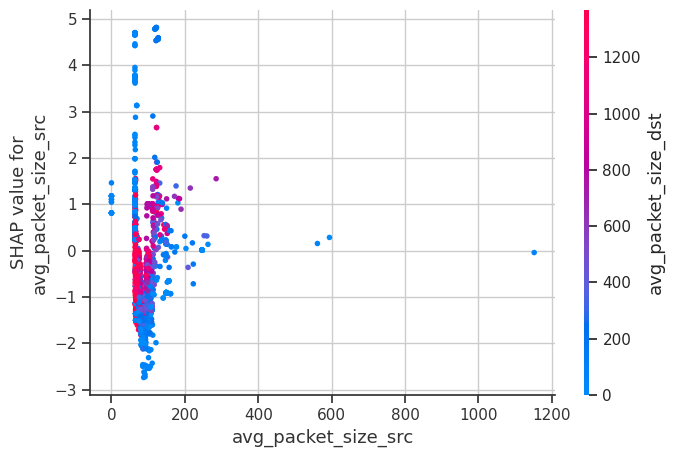


 Dependence plot for: sourceTCPFlagsDescription


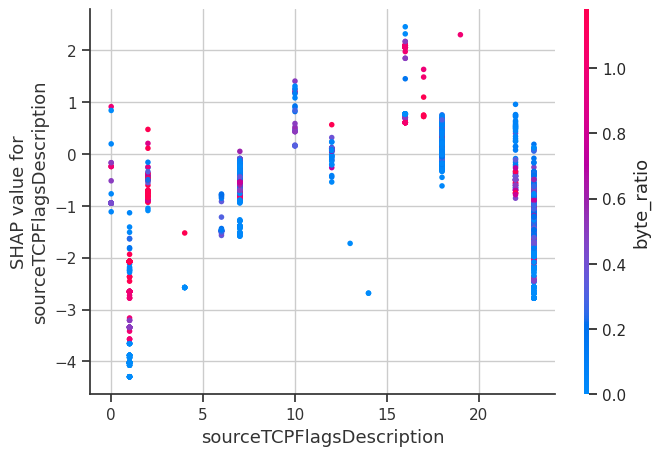


 Dependence plot for: avg_packet_size_dst


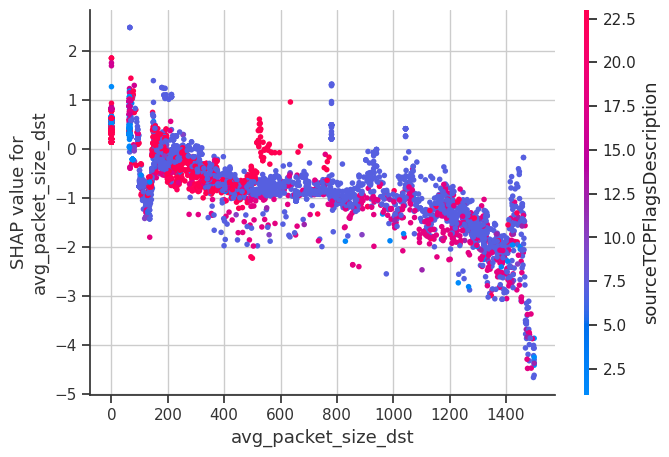


 Dependence plot for: packet_ratio


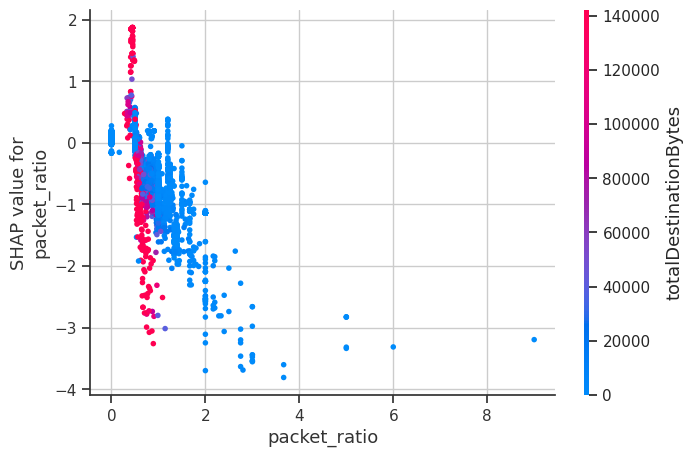

In [25]:
# Dependence plots for top features
for feat in top_feats.index:
    print(f"\n Dependence plot for: {feat}")
    shap.dependence_plot(feat, shap_df.values, X_sample, show=True)